In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from pylab import *

In [ ]:
image = io.imread('/content/sample_data/test.jpg')
image = color.rgb2lab(image)

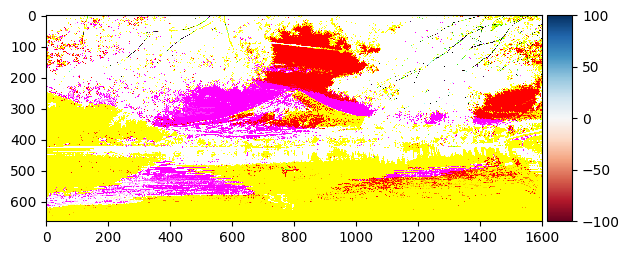

In [ ]:
figure(0)
io.imshow(image)

In [ ]:
# Calculate gradients
def calculate_lab_gradient(image):
    gradients = np.zeros(image.shape[:2])
    for y in range(1, image.shape[0] - 1):
        for x in range(1, image.shape[1] - 1):
            gradient_x = np.linalg.norm(image[y, x + 1] - image[y, x - 1]) # getting L2 norm of x derivative
            gradient_y = np.linalg.norm(image[y + 1, x] - image[y - 1, x]) # getting L2 norm of y derivative
            gradients[y, x] = np.sqrt(gradient_x ** 2 + gradient_y ** 2) # getting GRADIENT
    return gradients

In [ ]:
# Initialize cluster centers
def init_clusters_center(image, S):
    gradients = calculate_lab_gradient(image)  # getting image gradient

    height, width, _ = image.shape

    centers = []
    for y in range(S // 2, height, S):
        for x in range(S // 2, width, S):
            min_gradient = np.inf
            best_center = [x, y]

            for j in range(max(0, y - 1), min(height, y + 2)):
                for i in range(max(0, x - 1), min(width, x + 2)):
                    gradient = np.linalg.norm(gradients[j, i])

                    if gradient < min_gradient:
                        min_gradient = gradient
                        best_center = [i, j]

            # Add color information to the center
            lab = image[best_center[1], best_center[0]]
            centers.append([lab[0], lab[1], lab[2], best_center[0], best_center[1]])

    return centers

In [ ]:
# Show cluster BEFORE PASS IMG NEED CONVER TO RGB
def show_cluster_centers(image, cluster_centers):
    marked_image = np.copy(image)

    for center in cluster_centers:
        _, _, _, x, y = center
        cv2.circle(marked_image, (x, y), 5, (0, 0, 255), -1)  # Red color

    return marked_image

In [ ]:
# Assing pixels to clusters center
def assign_pixels_to_clusters(image, centers, S, m=50):
    distance = np.full(image.shape[:2], np.inf)  # Set distance = inf
    label = np.full(image.shape[:2], -1) # Set label = -1

    for i, center in enumerate(centers):
        cx, cy = int(center[-2]), int(center[-1])  # Getting cords

        for y in range(max(0, cy - S), min(image.shape[0], cy + S)):
            for x in range(max(0, cx - S), min(image.shape[1], cx + S)):
                pixel_lab = image[y, x]

                # Using paper formulas
                dlab = np.linalg.norm(center[:3] - pixel_lab)
                dxy = np.linalg.norm(np.array([cx, cy]) - np.array([x, y]))
                D = dlab + (m/S)*dxy

                if D < distance[y, x]:
                    distance[y, x] = D
                    label[y, x] = i

    return label

In [ ]:
# Show labels BEFORE PASS IMG NEED CONVER TO RGB
def show_colored_labels(image, labels):
    labels_uint8 = labels.astype(np.uint8)

    mask = np.zeros_like(image)

    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_mask = np.uint8(labels_uint8 == label)
        contours, _ = cv2.findContours(label_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(mask, contours, -1, (255, 255, 0), thickness=1)  # Adjust thickness as needed

    result = cv2.addWeighted(image, 0.6, mask, 0.4, 0)

    return result

In [ ]:
# Show labels and cluster centers
def SLIC_show(image, labels, centers):
    result = color.lab2rgb(image.copy())
    result = show_colored_labels(result, labels)
    result = show_cluster_centers(result, centers)
    return result

In [ ]:
# Update cluster centers
def update_cluster_centers(image_lab, labels, cluster_centers, S):
    new_centers = []

    # Iterate through each cluster center
    for i, center in enumerate(cluster_centers):
        y_center, x_center = int(center[4]), int(center[3])  # Getting cords

        # Define the boundary coordinates for the neighborhood area
        y_start = max(0, y_center - S)
        y_end = min(image_lab.shape[0], y_center + S)
        x_start = max(0, x_center - S)
        x_end = min(image_lab.shape[1], x_center + S)

        # Create a mask to identify cluster pixels in the neighborhood
        mask = (labels[y_start:y_end, x_start:x_end] == i)
        indices = np.argwhere(mask)

        # If there are pixels in the neighborhood associated with the cluster
        if len(indices) > 0:
            indices[:, 0] += y_start
            indices[:, 1] += x_start

            # Find new cluster center
            lab_sum = np.sum(image_lab[indices[:, 0], indices[:, 1]], axis=0)
            num_pixels = len(indices)
            new_center = [lab_sum[0] / num_pixels, lab_sum[1] / num_pixels, lab_sum[2] / num_pixels, np.mean(indices[:, 1]), np.mean(indices[:, 0])]
            new_centers.append(new_center)
        else:
            # If no retain current
            new_centers.append([center[0], center[1], center[2], center[3], center[4]])

    return np.array(new_centers)


In [ ]:
# Compose all part on SLIC
def SLIC(image, K):
    N = image.shape[0] * image.shape[1]  # Pixels in image
    S = round(np.sqrt(N/K)) # Superpixel center interval
    cluster_centers = init_clusters_center(image, S) # Getting list of centers coordinates
    labels = assign_pixels_to_clusters(image, cluster_centers, S) # Assign pixels to to the centers

    # Defining MSE  for learning
    threshold = 1.0
    error = threshold + 1.0
    prev_centers =  np.array(cluster_centers)
    i = 0
    while error > threshold:
        i=i+1
        print("Error:", error)
        prev_centers = np.array(cluster_centers.copy())
        labels = assign_pixels_to_clusters(image, cluster_centers, S)
        cluster_centers = np.array(update_cluster_centers(image, labels, cluster_centers, S))
        error = np.mean(np.sqrt(np.sum((prev_centers[:, :3] - cluster_centers[:, :3]) ** 2, axis=1)))


        # Show the current state of the segmentation
        plt.figure()
        plt.imshow(show_colored_labels(color.lab2rgb(image), labels))
        plt.title(f'Iteration {i}')
        plt.show()

    return labels

Error: 2.0


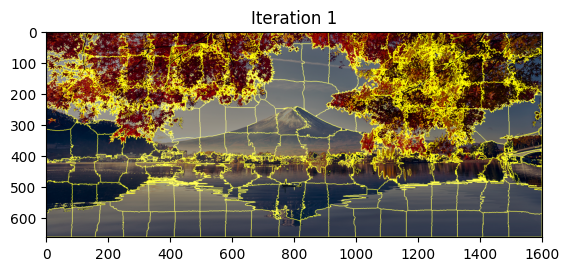

Error: 11.507431071347069


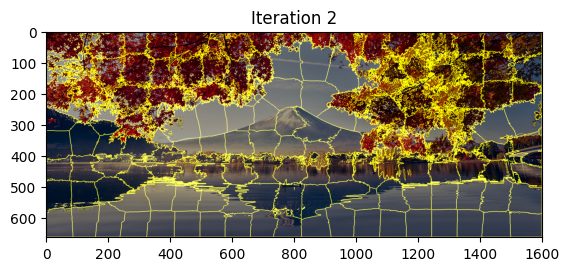

Error: 2.5092800354567393


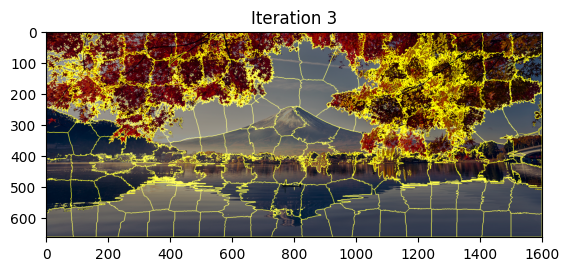

Error: 1.4149350853716083


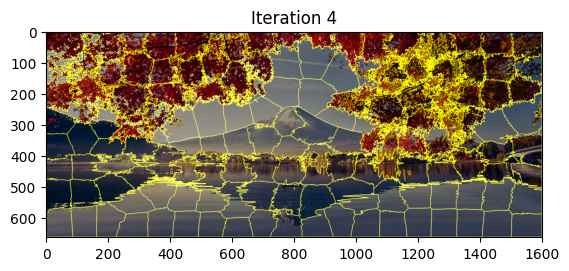

In [ ]:
segments = SLIC(image, 156)